In [6]:
# geopython env + mxnet1.6.0 env
import numpy as np
import pandas as pd
import imageio
import os
from sklearn.metrics import accuracy_score, matthews_corrcoef, confusion_matrix, r2_score
import higra as hg
import scipy.ndimage as si
from skimage import measure
import pickle

import geopandas as gpd

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
%matplotlib inline

# Vectorize predictions

## (1) Compare rasters at same resolution

### Original resolution

## (2) Compare vectorized fields

In [ ]:
'../data/general_blockchain/airbus_geotiff/large/'

In [ ]:
splits_path = '../data/splits/india_planetImagery_splits_20x20_v2.csv'
splits_df = pd.read_csv(splits_path, dtype=str)
splits_df['image_id'] = splits_df['image_id'].str.zfill(4)
train_ids = sorted(splits_df[splits_df['fold'] == 'train']['image_id'].values)
val_ids = sorted(splits_df[splits_df['fold'] == 'val']['image_id'].values)
test_ids = sorted(splits_df[splits_df['fold'] == 'test']['image_id'].values)

results_dir = '../results/india/GeneralBlockchain/'
model_folder = 'fractal-resunet_Airbus_nfilter-32_depth-6_bs-5_lr-0.001_1x-3x-downsampled-erosion2px_finetuned'
resolution_folder = 'Airbus_3x_downsampled'
instances_folder = 'instances_full'

for image_id in val_ids:
    instance_folder_path = os.path.join(results_dir, model_folder, resolution_folder, instances_folder)
    instance_path = os.path.join(instance_folder_path, 'airbus_geowiki_C{}.png'.format(image_id))
    

In [15]:
def InstSegm(extent, boundary, t_ext=0.4, t_bound=0.2):
    """
    INPUTS:
    extent : extent prediction
    boundary : boundary prediction
    t_ext : threshold for extent
    t_bound : threshold for boundary
    OUTPUT:
    instances
    """

    # Threshold extent mask
    ext_binary = np.uint8(extent >= t_ext)

    # Artificially create strong boundaries for
    # pixels with non-field labels
    input_hws = np.copy(boundary)
    input_hws[ext_binary == 0] = 1

    # Create the directed graph
    size = input_hws.shape[:2]
    graph = hg.get_8_adjacency_graph(size)
    edge_weights = hg.weight_graph(
        graph,
        input_hws,
        hg.WeightFunction.mean
    )

    tree, altitudes = hg.watershed_hierarchy_by_dynamics(
        graph,
        edge_weights
    )
    
    # Get individual fields
    # by cutting the graph using altitude
    instances = hg.labelisation_horizontal_cut_from_threshold(
        tree,
        altitudes,
        threshold=t_bound)
    
    instances[ext_binary == 0] = -1

    return instances

In [54]:
t_ext = 0.1
t_bound = 0.4

results_dir = '../results/india/GeneralBlockchain/fractal-resunet_Airbus_nfilter-32_depth-6_bs-5_lr-0.001_1x-3x-downsampled-erosion2px_finetuned/Airbus_original/'
# results_dir = '../results/india/GeneralBlockchain/fractal-resunet_Airbus_nfilter-32_depth-6_bs-5_lr-0.001_2x-downsampled-erosion1px_finetuned/Airbus_2x_downsampled/'
instances_dir = os.path.join(results_dir, 'instances_full')

if not os.path.exists(instances_dir):
    os.makedirs(instances_dir)

for i, image_id in enumerate(['0036']):
    if i % 10 == 0:
        print(i)

#     extent = np.load(os.path.join(results_dir, 'extent_predictions/airbus_geowiki_C{}.npy'.format(image_id)))
#     boundary = np.load(os.path.join(results_dir, 'boundary_predictions/airbus_geowiki_C{}.npy'.format(image_id)))
    extent = imageio.imread(os.path.join(results_dir, 'extent_full/airbus_geowiki_C{}.png'.format(image_id)))
    extent = np.array(extent, dtype=np.float32) / 255.
    boundary = imageio.imread(os.path.join(results_dir, 'boundary_full/airbus_geowiki_C{}.png'.format(image_id)))
    boundary = np.array(boundary, dtype=np.float32) / 255.

    instances = InstSegm(extent, boundary, t_ext=t_ext, t_bound=t_bound)

    # map instances to better range for plotting
    unique_instances = sorted(np.unique(instances))
    min_instance = unique_instances[1]
    max_instance = unique_instances[-1]
    n_instances = len(unique_instances)
    instance_map = {x: i for i, x in enumerate(unique_instances)}
    def map_values(x):
        return instance_map[x]
    instances_mapped = np.array(list(map(map_values, instances.flatten()))).reshape( 
        instances.shape[0], instances.shape[1])
    
    np.save(os.path.join(instances_dir, 'airbus_geowiki_C{}.npy'.format(image_id)), instances_mapped)

0


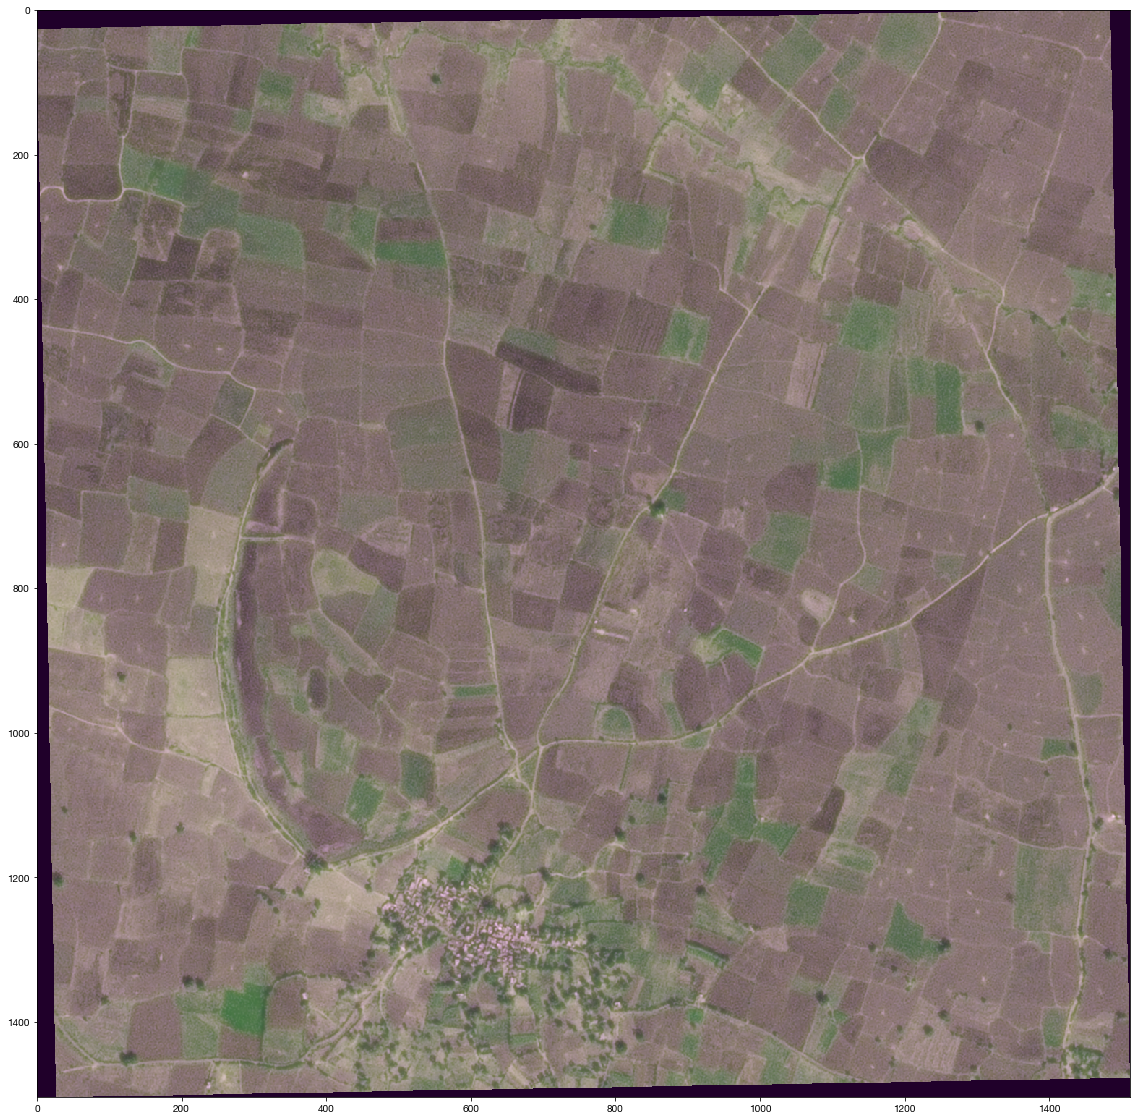

In [51]:
image_id = '0036'
original_label = imageio.imread('../data/general_blockchain/airbus_false_color/large/original/airbus_geowiki_C{}.png'.format(image_id))
fig, ax = plt.subplots(1, 1, figsize=(20,20))
plt.imshow(original_label)
plt.show()

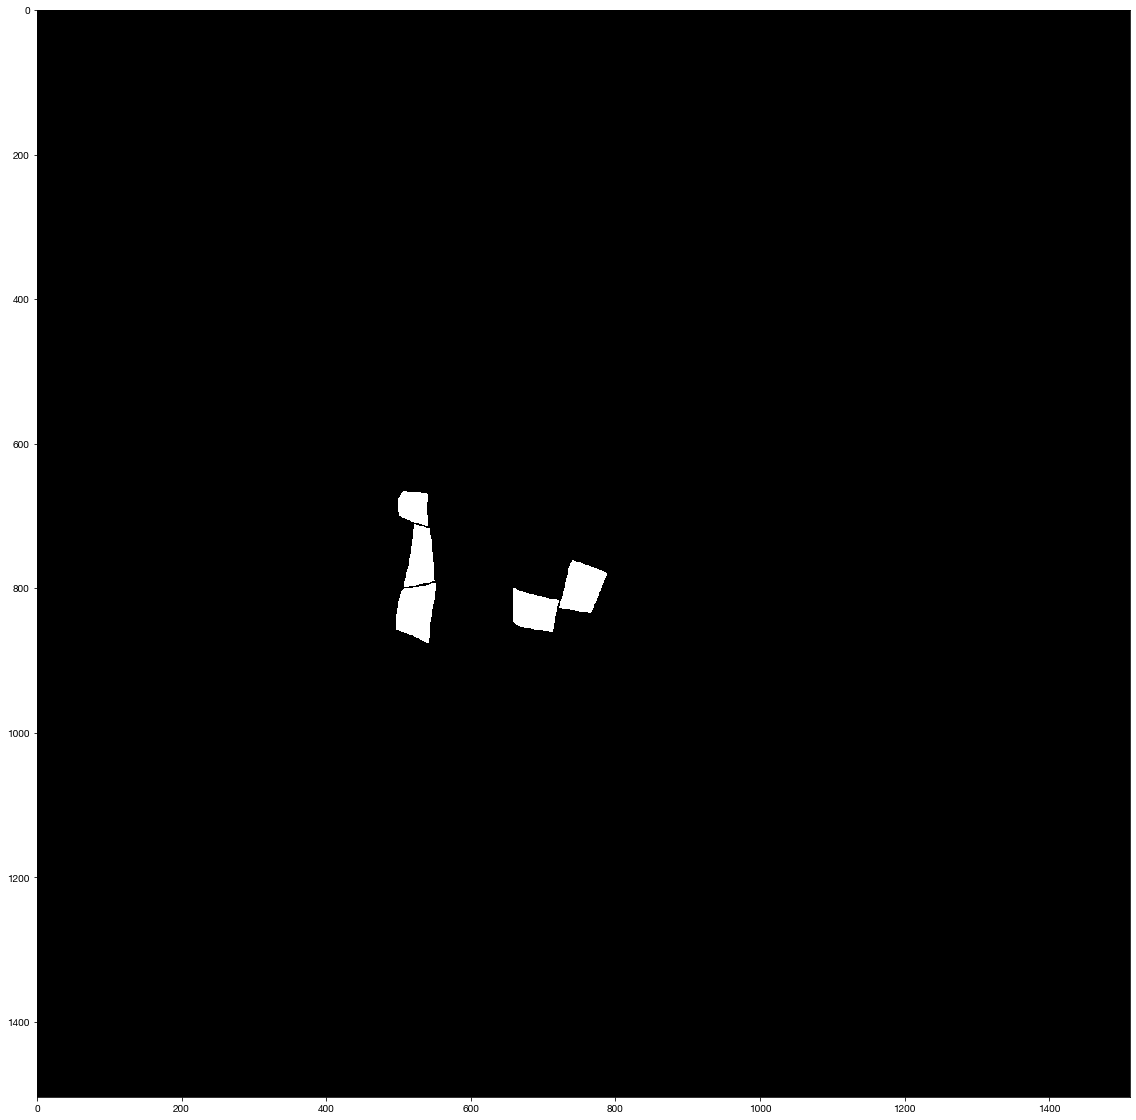

In [52]:
original_label = imageio.imread('../data/general_blockchain/airbus_labels/large/original/airbus_geowiki_C{}.png'.format(image_id))
fig, ax = plt.subplots(1, 1, figsize=(20,20))
plt.imshow(original_label, cmap='Greys_r')
plt.show()

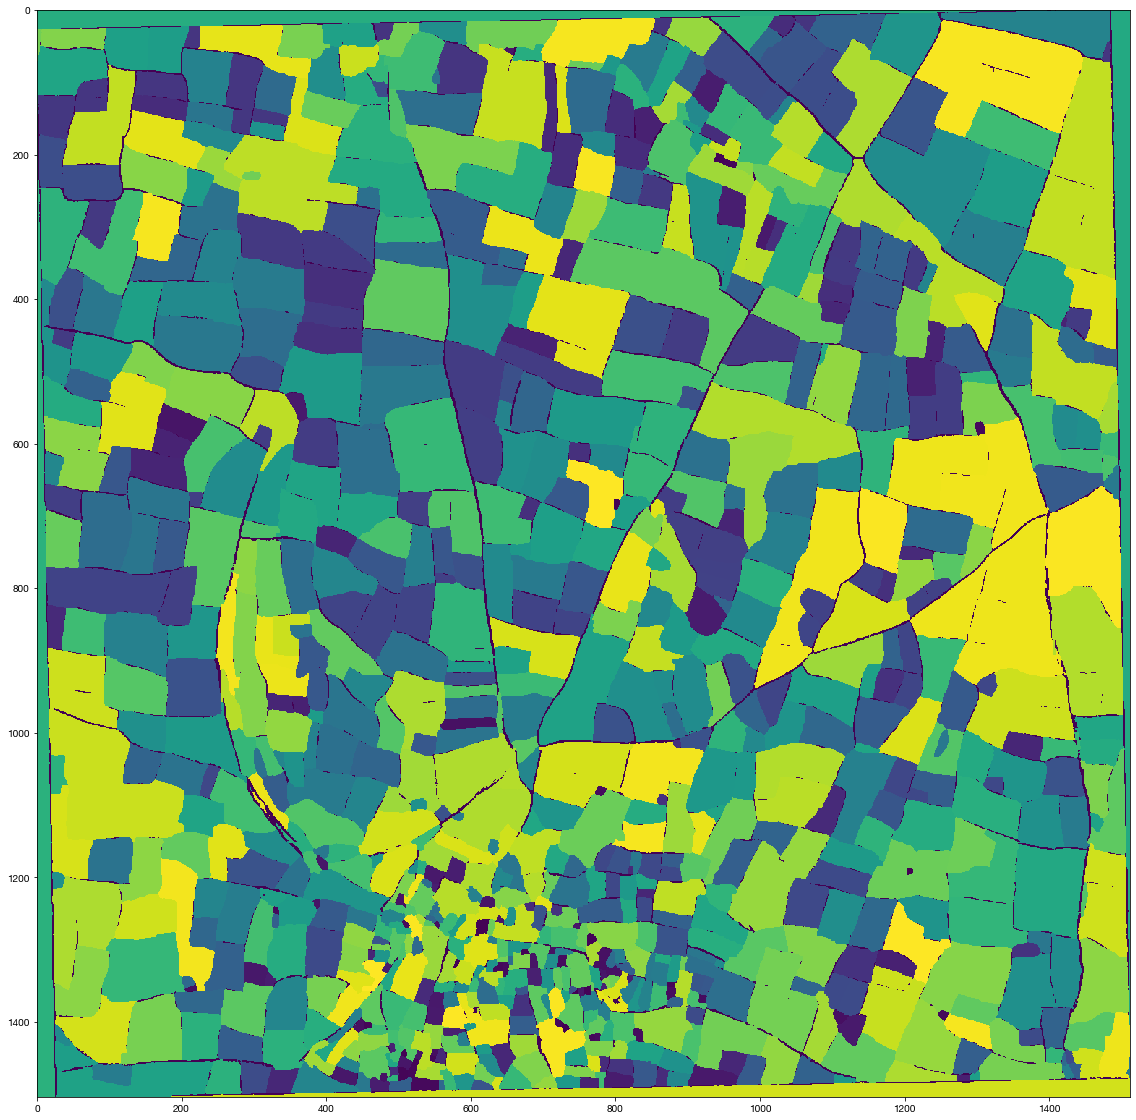

In [55]:
instances = np.load('../results/india/GeneralBlockchain/fractal-resunet_Airbus_nfilter-32_depth-6_bs-5_lr-0.001_1x-3x-downsampled-erosion2px_finetuned/Airbus_original/instances_full/airbus_geowiki_C{}.npy'.format(image_id))
fig, ax = plt.subplots(1, 1, figsize=(20,20))
plt.imshow(instances)
plt.show()

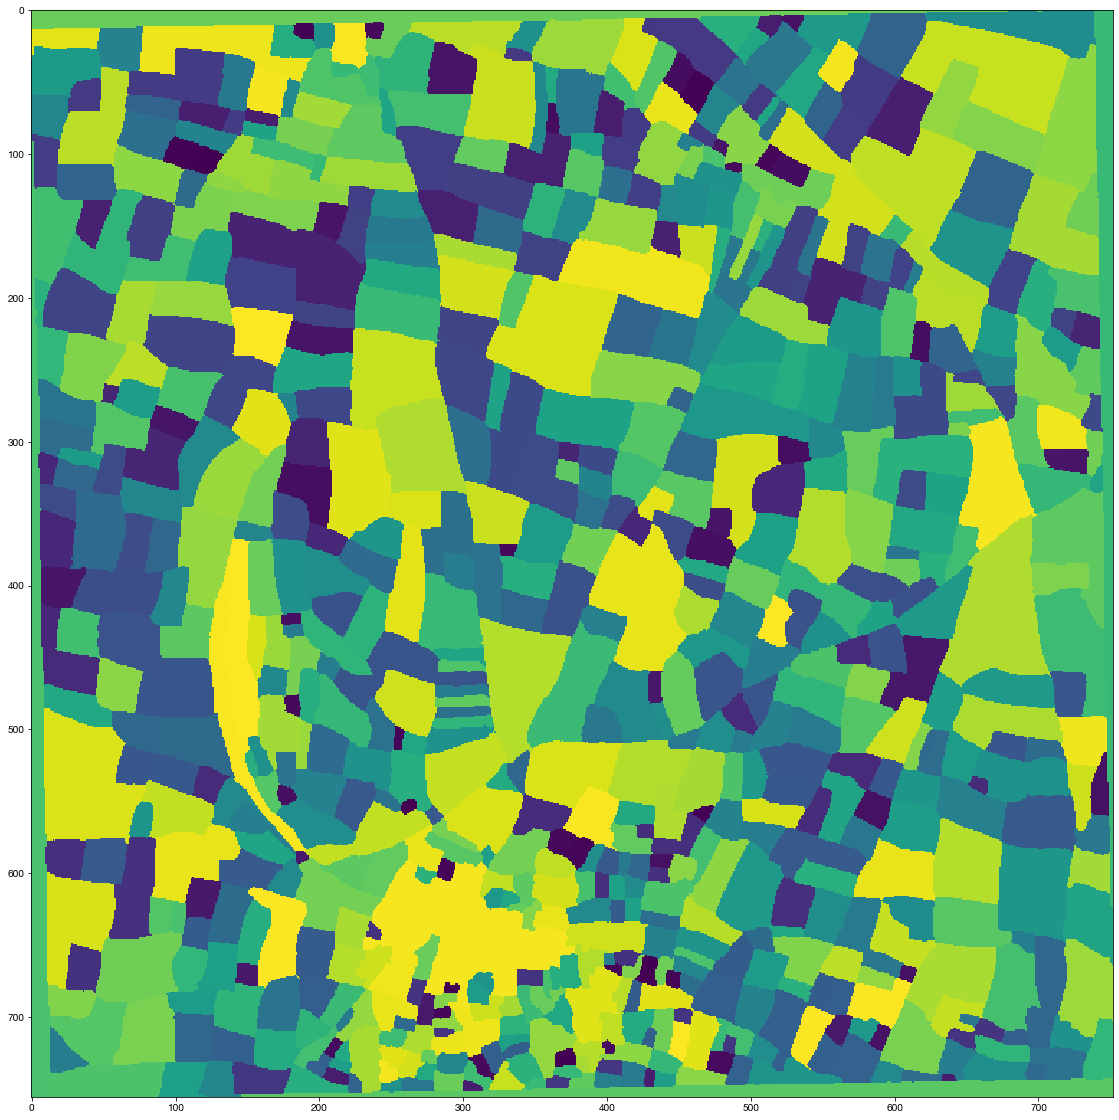

In [53]:
instances = np.load('../results/india/GeneralBlockchain/fractal-resunet_Airbus_nfilter-32_depth-6_bs-5_lr-0.001_1x-3x-downsampled-erosion2px_finetuned/Airbus_2x_downsampled/instances_full/airbus_geowiki_C{}.npy'.format(image_id))
fig, ax = plt.subplots(1, 1, figsize=(20,20))
plt.imshow(instances)
plt.show()

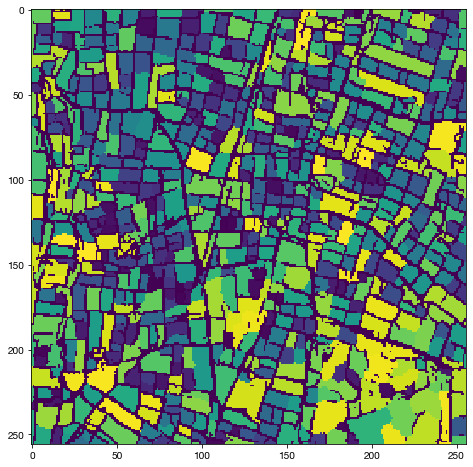

In [12]:
instances = np.load('../results/india/GeneralBlockchain/fractal-resunet_Airbus_nfilter-32_depth-6_bs-5_lr-0.001_1x-3x-downsampled-erosion2px_finetuned/Airbus_3x_downsampled/instances_full/airbus_geowiki_C0320.npy')
fig, ax = plt.subplots(1, 1, figsize=(8,8))
plt.imshow(instances)
plt.show()

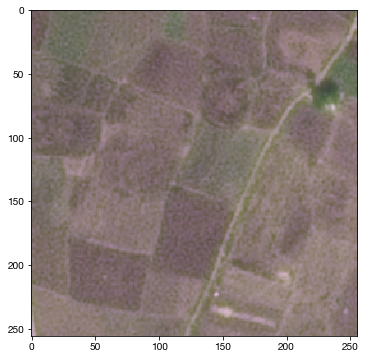

In [58]:
original_label = imageio.imread('../data/general_blockchain/airbus_false_color/large/original_val/airbus_geowiki_C{}.png'.format(image_id))
fig, ax = plt.subplots(1, 1, figsize=(6,6))
plt.imshow(original_label)
plt.show()

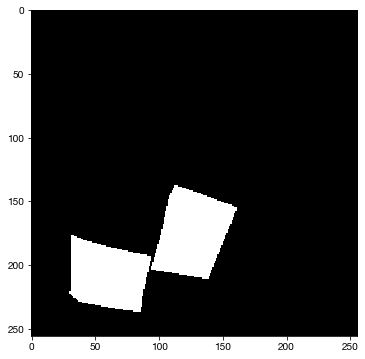

In [60]:
original_label = imageio.imread('../data/general_blockchain/airbus_labels/large/original_val/airbus_geowiki_C{}.png'.format(image_id))
fig, ax = plt.subplots(1, 1, figsize=(6,6))
plt.imshow(original_label, cmap='Greys_r')
plt.show()

In [ ]:
'../data/general_blockchain/airbus_labels/large/original/'

In [7]:
labeled_fields = gpd.read_file('../data/general_blockchain/india_fields_with_area_reprojected.shp')

In [8]:
labeled_fields

area  sample                                           geometry
0      9620.550048       0  POLYGON ((8138149.842 3036600.654, 8138149.842...
1      5244.485268       0  POLYGON ((8138285.352 3036483.265, 8138285.352...
2      1983.845942       0  POLYGON ((8138336.476 3036433.441, 8138336.476...
3      5191.243054       0  POLYGON ((8138059.502 3036146.623, 8138059.502...
4      5728.435942       0  POLYGON ((8137809.812 3036188.696, 8137816.267...
...            ...     ...                                                ...
10008   753.823903    2002  POLYGON ((10184008.471 3076854.973, 10184008.4...
10009  2500.742071    2002  POLYGON ((10184087.402 3076845.532, 10184089.3...
10010  2002.759594    2002  POLYGON ((10184010.953 3076787.234, 10184010.9...
10011  4013.147174    2002  POLYGON ((10184112.718 3076697.832, 10184112.7...
10012   456.357790    2002  POLYGON ((10184186.679 3076686.723, 10184186.6...

[10013 rows x 3 columns]

In [15]:
labeled_fields['sample'].unique()

array([   0,    1,    2, ..., 2000, 2001, 2002])

In [3]:
len(os.listdir('../results/india/GeneralBlockchain/fractal-resunet_Airbus_nfilter-32_depth-6_bs-5_lr-0.001_1x-3x-downsampled-erosion2px_finetuned/Airbus_2x_downsampled/extent_full/'))

300

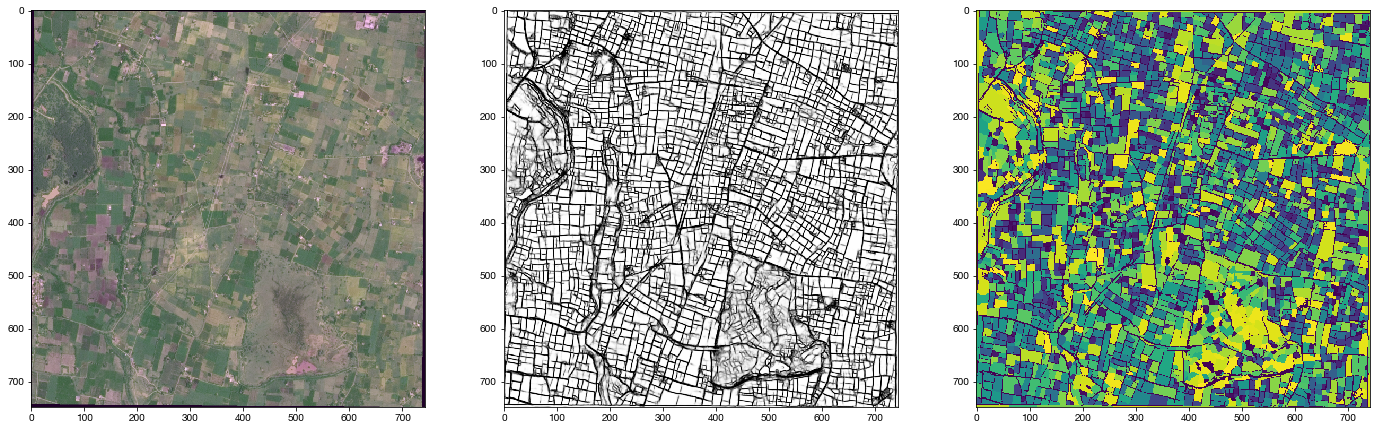

In [4]:
img_path = '../data/general_blockchain/airbus_false_color/large/2x_downsample/airbus_geowiki_C0320.png'
img = imageio.imread(img_path)
label_path = '../results/india/GeneralBlockchain/fractal-resunet_Airbus_nfilter-32_depth-6_bs-5_lr-0.001_1x-3x-downsampled-erosion2px_finetuned/Airbus_2x_downsampled/extent_full/airbus_geowiki_C0320.png'
label = imageio.imread(label_path)
instance_path = '../results/india/GeneralBlockchain/fractal-resunet_Airbus_nfilter-32_depth-6_bs-5_lr-0.001_1x-3x-downsampled-erosion2px_finetuned/Airbus_2x_downsampled/instances_full/airbus_geowiki_C0320.npy'
instance = np.load(instance_path)

fig, ax = plt.subplots(1, 3, figsize=(24, 8))
ax[0].imshow(img)
ax[1].imshow(label, cmap='Greys_r')
ax[2].imshow(instance)
plt.show()